# Trying out a Genetic Algorithm with SDXL-Turbo exploring the prompt embedding latent space

In [3]:
from evolutionary.plotting import plot_fitness_statistics
from model_helpers.auto_pipeline import auto_diffusion_pipeline
from diffusers.utils import logging
from evolutionary.image_processing import create_animation_from_generations, create_generation_image_grid, save_images_from_generation

In [4]:
prompts = [
    "Futuristic cityscape under a dual sunset",
    "Surreal garden with glow-in-the-dark plants",
    "Underwater scene featuring a coral-built city",
    "Robot and medieval knight engaged in a chess match",
    "Portrait composed entirely of musical instruments",
    "Bustling Martian market scene",
    "Giant tree hosting houses and shops on its branches",
    "Abstract representation embodying the concept of time",
    "Village with all glass-made houses",
    "Victorian city populated by steampunk animals",
    "Floating books replacing shelves in a library",
    "Desert landscape with blue sand and purple cacti",
    "Modern city blending ancient Roman architectural styles",
    "Fantasy world map with inverted land and sky",
    "Post-apocalyptic nature reclaiming an urban landscape",
    "Moon's surface featuring an ice cream truck",
    "Sky parade with floating ships",
    "Regal portrait of a cat in 18th-century monarch attire",
    "Dolphins swimming through cloud formations",
    "Egyptian pyramids merged with futuristic tech",
    "Mystical forest illuminated by bioluminescent flora and fauna",
    "Underwater jazz concert spectacle",
    "Storm painting crafted from various musical instruments",
    "Chessboard with miniature city pieces",
    "Surreal transition of books into birds",
    "Secret village nestled inside a volcano",
    "Computer interior reimagined as an urban landscape",
    "Amusement park themed around candy delights",
    "Space-bound art gallery",
    "Cyberpunk twist on the Renaissance era",
    "Crystal-based plant life in a garden setting",
    "Ancient civilization thriving on an alien planet",
    "Wildlife and urban landscapes in a harmonious blend",
    "Single landscape depicting all four seasons",
    "Pirate and flying shark battle scene",
    "Utopian society concept floating on a cloud",
    "Fantasy scene where shadows are colorful",
    "Water-constructed buildings in a city",
    "Futuristic tech hidden within an ancient temple",
    "Giant book with each page being a different world",
    "Ocean and sky swapping places in a landscape",
    "Renaissance noble portrait of an alien",
    "Tree growing miniature cities as fruits",
    "Mountain range resembling sleeping dragons",
    "Market specializing in bottled dreams",
    "Concert uniting classical musicians with rock stars",
    "Planetary landscape with visible ringed sky",
    "Cityscape showcasing buildings from various historical eras",
    "Watercolor-animated animals in a surreal setting",
    "Ancient ruins interspersed with holographic projections",
    'Abandoned amusement park overrun by nature, with rides encased in vines',
    'High-speed chase between hover cars in a neon-lit megastructure',
    'Interstellar zoo featuring cosmic beasts from different galaxies',
    'Subterranean city lit by bioluminescent fungi and crystals',
    'Aerial view of a city where roads and canals are intertwined',
    'Dystopian world where giant screens display the only source of sunlight',
    'Ice castle on a cloud, accessible only by flying creatures',
    'Surreal dreamscape with floating islands connected by rope bridges',
    'Wasteland with a lone, vibrant tree sheltering a myriad of species',
    'Steampunk laboratory with intricate machinery powered by steam',
    'Galactic fair with aliens trading stars and comets',
    'A library where each book opens a portal to another universe',
    'Renaissance fair in a futuristic setting, blending past and future',
    'Garden maze made of mirrors reflecting infinite skies',
    'Night market selling potions and charms under a bioluminescent moon',
    'Arctic village on the back of a giant, wandering polar bear',
    'Volcanic eruption revealing an ancient, untouched civilization',
    'Opera house where the performers are ghosts, singing untold histories',
    'Time-frozen battlefield with statuesque soldiers from different eras',
    'Oceanic abyss where shipwrecks form the architecture of an underwater city',
    'Skyline where each building is a musical instrument, playing in the wind',
    'Circus train traveling through dimensional portals, showcasing interdimensional acts',
    'Haunted mansion where each room leads to a different point in time',
    'Festival of lights where the sky is filled with glowing kites at night',
    'Underground network of caves filled with ancient, mechanical beasts',
    'A clockwork universe where planets are interconnected gears',
    'Enchanted forest with trees that whisper secrets of the universe',
    'City where gravity shifts, allowing for multidimensional architecture',
    'A dystopian society where memories are currency',
    'Rainbow waterfall cascading into a hidden elfin city',
    'Battlefield of chess with live mythical creatures as pieces',
    'A colony on a comet, farming stardust',
    'Post-apocalyptic world where technology is powered by magic',
    'Snow globe village that experiences eternal winter',
    'Grand canyon filled with skyscraper-sized totem poles',
    'A world where shadows tell different stories than their objects',
    'Museum of extinct species, with lifelike holograms',
    'A city built inside the ribcage of a giant creature',
    'A festival where balloons carry entire houses into the sky',
    'A secret society meeting in the catacombs beneath an ancient city',
    'A desert oasis that is actually a mirage hiding an advanced civilization',
    'An island where every grain of sand is a different color',
    'A palace made entirely of reflective obsidian, showing infinite reflections',
    'A space elevator connecting Earth to a space station in geostationary orbit',
    'A train that travels through the center of the Earth',
    'An ancient library buried under the desert, guarded by sphinxes',
    'A city built on the back of a giant, wandering tortoise',
    'A space colony on Jupiter’s moon, Europa, under the ice',
    'An art gallery where the paintings come to life at night',
    'A world where plants are the dominant species, and cities are alive'
]

print(len(prompts))

100


In [5]:
logging.disable_progress_bar() # Or else your output will be full of progress bars
logging.set_verbosity_error() # Enable again if you are having problems

# Factory for loading the DiffusionPipeline from the HuggingFace Hub
def setup_pipeline():
    pipe = auto_diffusion_pipeline("stabilityai/sdxl-turbo")
    pipe.set_progress_bar_config(disable=True)
    return pipe

In [6]:
from evolutionary.prompt_encoding.image_creation import SDXLPromptEmbeddingImageCreator
from evolutionary.prompt_encoding.variation import PooledArithmeticCrossover, PooledUniformGaussianMutator, UniformGaussianMutatorArguments
from evolutionary.selectors import TournamentSelector
from evolutionary.algorithms.ga import GeneticAlgorithm
from evolutionary.image_evaluators import AestheticsImageEvaluator  

population_size = 100
num_generations = 200
batch_size = 1

# Create the necessary components for the genetic algorithm
creator = SDXLPromptEmbeddingImageCreator(pipeline_factory=setup_pipeline, batch_size=batch_size, inference_steps=3)
evaluator = AestheticsImageEvaluator()  
crossover = PooledArithmeticCrossover(crossover_rate=0.5, crossover_rate_pooled=0.5)
# clamp_range was evaluated through find_clamp_range.py
mutation_arguments = UniformGaussianMutatorArguments(mutation_rate=0.1, mutation_strength=2, clamp_range=(-900, 900)) 
mutation_arguments_pooled = UniformGaussianMutatorArguments(mutation_rate=0.1, mutation_strength=0.3, clamp_range=(-8, 8))
mutator = PooledUniformGaussianMutator(mutation_arguments, mutation_arguments_pooled)
selector = TournamentSelector(tournament_size=3)

# Prepare initial arguments
init_args = [creator.arguments_from_prompt(prompts[i]) for i in range(population_size)]

# Create and run the genetic algorithm
ga = GeneticAlgorithm(
    population_size=population_size,
    num_generations=num_generations,
    solution_creator=creator,
    evaluator=evaluator,
    mutator=mutator,
    crossover=crossover,
    selector=selector,
    initial_arguments=init_args,
    elitism_count=1,
    post_evaluation_callback=lambda g, a: save_images_from_generation(a.population, g),
)

Loaded StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.25.0",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Model loaded successfully.


In [7]:
best_solution = ga.run()

Generation 0 started.
Generation 1 started.
Generation 2 started.
Generation 3 started.
Generation 4 started.
Generation 5 started.
Generation 6 started.
Generation 7 started.
Generation 8 started.
Generation 9 started.
Generation 10 started.
Generation 11 started.
Generation 12 started.
Generation 13 started.
Generation 14 started.
Generation 15 started.
Generation 16 started.
Generation 17 started.
Generation 18 started.
Generation 19 started.
Generation 20 started.
Generation 21 started.
Generation 22 started.
Generation 23 started.
Generation 24 started.
Generation 25 started.
Generation 26 started.
Generation 27 started.
Generation 28 started.
Generation 29 started.
Generation 30 started.
Generation 31 started.
Generation 32 started.
Generation 33 started.
Generation 34 started.
Generation 35 started.
Generation 36 started.
Generation 37 started.
Generation 38 started.
Generation 39 started.
Generation 40 started.
Generation 41 started.
Generation 42 started.
Generation 43 started

8.676226615905762


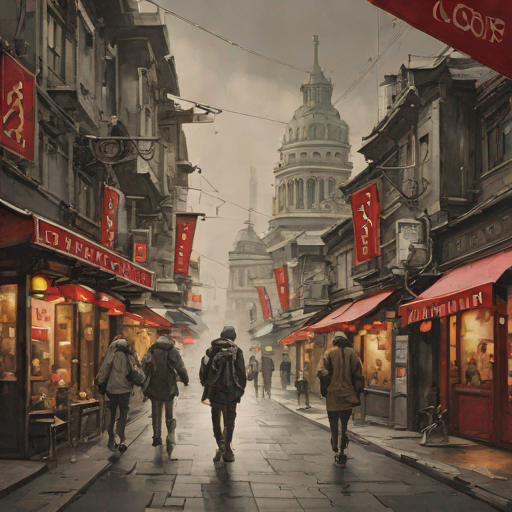

In [8]:
from diffusers.utils import make_image_grid

# Show best solution
batch_size = 1
print(best_solution.fitness)
make_image_grid(best_solution.result.images, 1, batch_size)

## Visualize the evolution

In [1]:
from IPython.display import Video
Video(filename="ga_200gen_100pop_aesthetic.mp4")

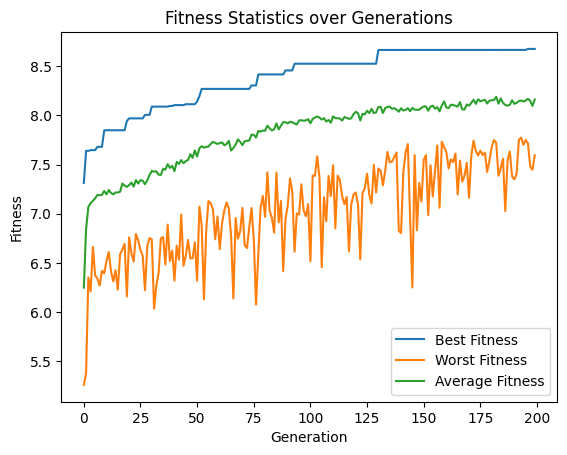

In [9]:
plot_fitness_statistics(ga)

In [3]:
!jupyter nbconvert --to html ga_200gen_100pop_aesthetic.ipynb

[NbConvertApp] Converting notebook ga_200gen_100pop_aesthetic.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 1058671 bytes to ga_200gen_100pop_aesthetic.html
